In [66]:
import numpy as np
import pandas as pd
import os
import nltk
import matplotlib.pyplot as plt
%matplotlib inline

## Reading CNN Files

In [67]:
cnn_path = '/home/shailesh/mission/emailscandals/'
cnn_docs = []
for filename in os.listdir(cnn_path):
    f=open(os.path.join(cnn_path,filename),'r')
    cnn_docs.append(f.read())

## Reading FOX Files

In [68]:
fox_path = '/home/shailesh/mission/foxemailscandals/'
fox_docs = []
for filename in os.listdir(fox_path):
    f=open(os.path.join(fox_path,filename),'r')
    fox_docs.append(f.read())

In [69]:
print(len(cnn_docs),len(fox_docs))

110 68


## BAG OF WORDS Representation

In [70]:
from sklearn.feature_extraction.text import CountVectorizer

In [71]:
vectorizer = CountVectorizer()

Learning the VOCABULARY 

In [72]:
vectorizer.fit(fox_docs+cnn_docs)
vocab = vectorizer.vocabulary_

In [73]:
len(vocab)

12561

Creating Document term Matrix..row as docid col as tokenid

In [74]:
all_docs = fox_docs + cnn_docs
len(all_docs)
fox_bow = vectorizer.transform(fox_docs).toarray()
cnn_bow = vectorizer.transform(cnn_docs).toarray()

Applying PCA to analyse docs

In [75]:
from sklearn.decomposition import PCA

In [76]:
pca = PCA(n_components=2)
reduced_fox_bow = pca.fit_transform(fox_bow)
reduced_cnn_bow = pca.fit_transform(cnn_bow)

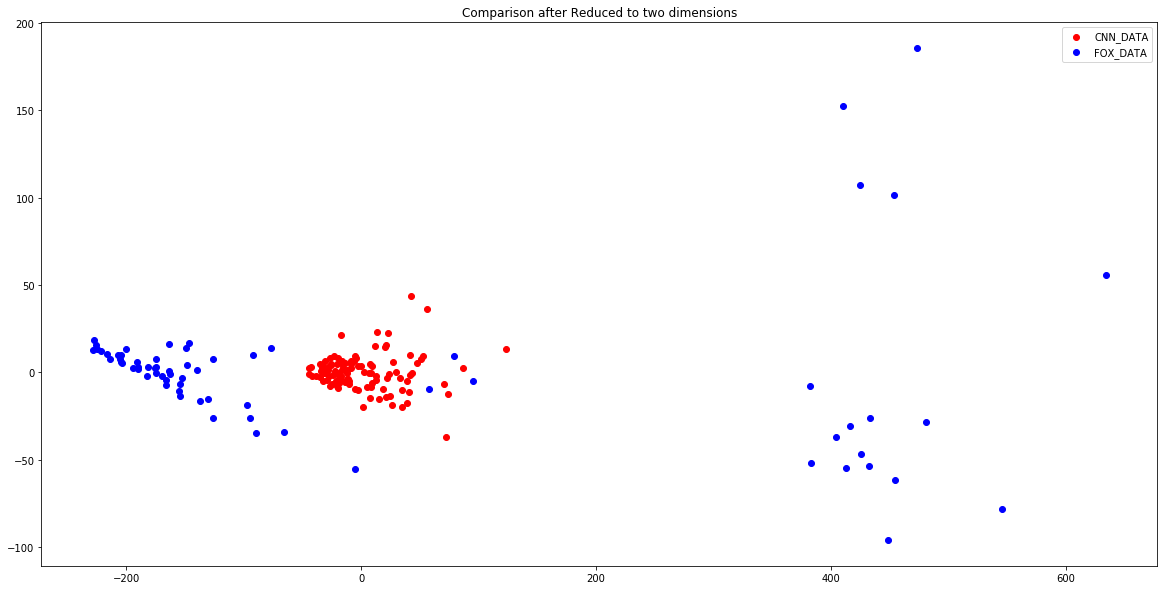

In [77]:
plt.figure(figsize=(20,10))
plt.scatter(reduced_cnn_bow[:,0],reduced_cnn_bow[:,1],color = 'red',label = 'CNN_DATA')
plt.scatter(reduced_fox_bow[:,0],reduced_fox_bow[:,1],color = 'blue',label = 'FOX_DATA')
plt.title('Comparison after Reduced to two dimensions')
plt.legend()

## Bag of Words after removing Stop Words and then Analysing

12274


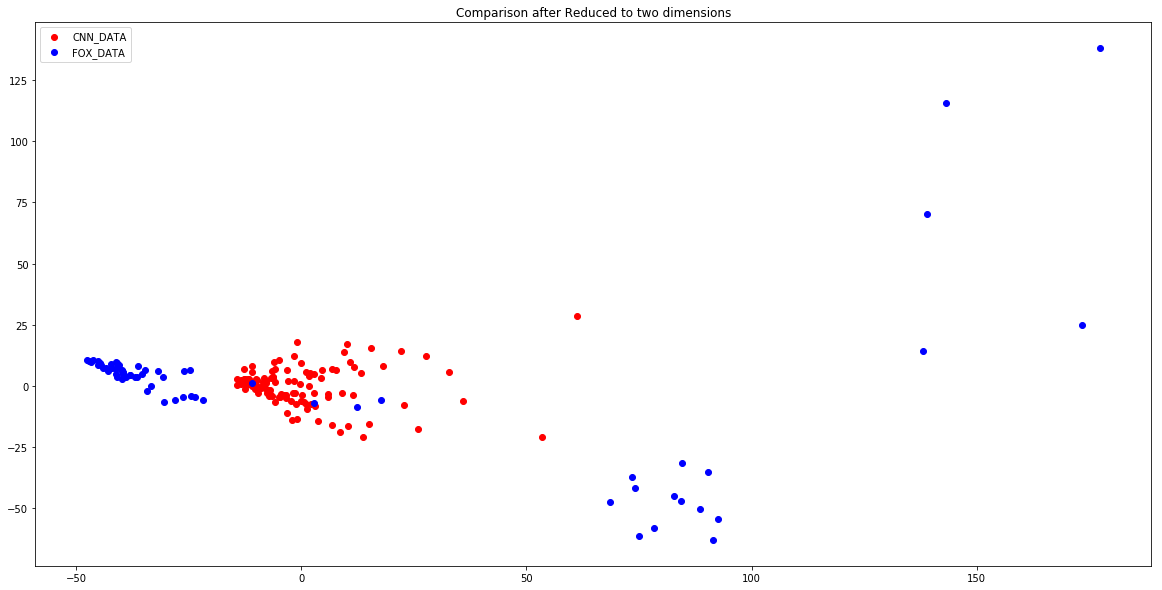

In [78]:
vectorizer = CountVectorizer(stop_words='english')
vectorizer.fit(fox_docs+cnn_docs)
print(len(vectorizer.vocabulary_))
fox_bow = vectorizer.transform(fox_docs)
cnn_bow = vectorizer.transform(cnn_docs)
pca = PCA(n_components=2)
reduced_fox_bow = pca.fit_transform(fox_bow.toarray())
reduced_cnn_bow = pca.fit_transform(cnn_bow.toarray())
plt.figure(figsize=(20,10))
plt.scatter(reduced_cnn_bow[:,0],reduced_cnn_bow[:,1],color = 'red',label = 'CNN_DATA')
plt.scatter(reduced_fox_bow[:,0],reduced_fox_bow[:,1],color = 'blue',label = 'FOX_DATA')
plt.title('Comparison after Reduced to two dimensions')
plt.legend()

## Top 20 Words with max frequency in FOX-News Data

In [79]:
words = vectorizer.get_feature_names()
summing = np.sum(fox_bow.toarray(),axis=0)
zipped = zip(words,summing)
zipped = set(zipped)
zipped = sorted(zipped,key = lambda x: x[1],reverse=True)

In [80]:
from wordcloud import WordCloud

(-0.5, 399.5, 199.5, -0.5)

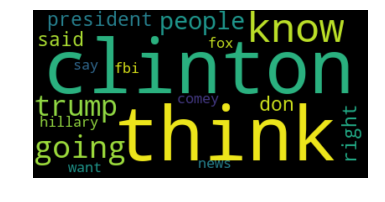

In [81]:
wc = WordCloud().generate(" ".join([i[0] for i in zipped[:20]]))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")

## Top 20 Words with max frequency in CNN Data

(-0.5, 399.5, 199.5, -0.5)

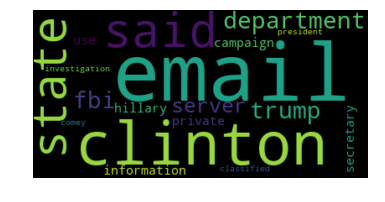

In [82]:
summing = np.sum(cnn_bow.toarray(),axis=0)
zipped = zip(words,summing)
zipped = set(zipped)
zipped = sorted(zipped,key = lambda x: x[1],reverse=True)
wc = WordCloud().generate(" ".join([i[0] for i in zipped[:20]]))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")

## Tf-Idf

In [83]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [84]:
tfidf_vect = TfidfVectorizer(stop_words='english')
tfidf_vect.fit(fox_docs+cnn_docs)
vocab = tfidf_vect.vocabulary_

In [85]:
len(vocab)

12274

In [86]:
fox_tfidf = tfidf_vect.transform(fox_docs)
cnn_tfidf = tfidf_vect.transform(cnn_docs)

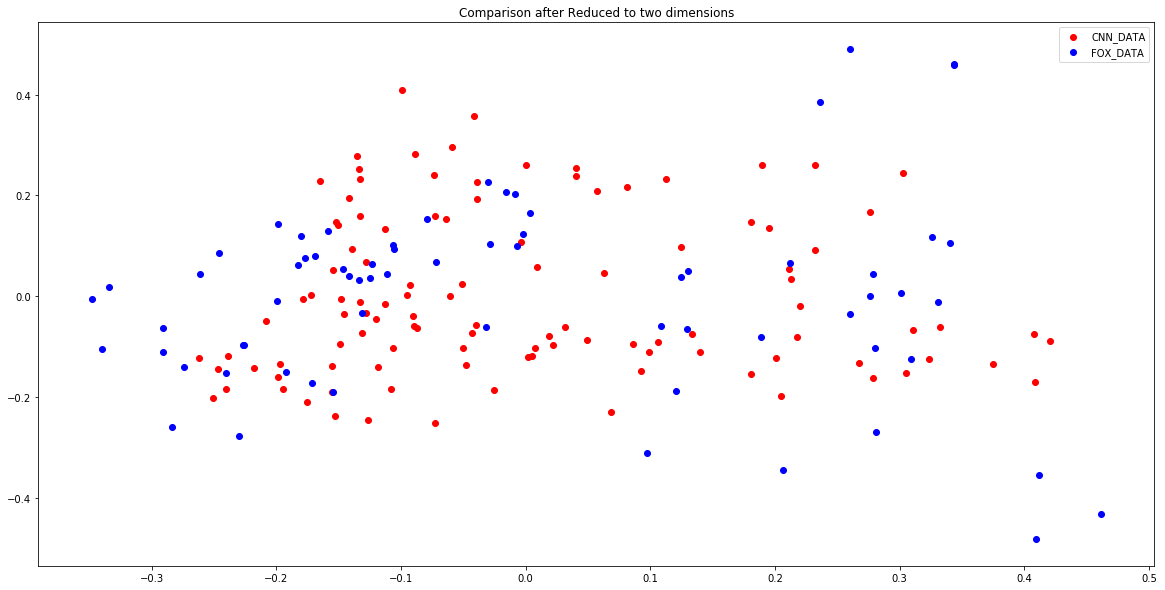

In [87]:
pca = PCA(n_components=2)
reduced_fox_bow = pca.fit_transform(fox_tfidf.toarray())
reduced_cnn_bow = pca.fit_transform(cnn_tfidf.toarray())
plt.figure(figsize=(20,10))
plt.scatter(reduced_cnn_bow[:,0],reduced_cnn_bow[:,1],color = 'red',label = 'CNN_DATA')
plt.scatter(reduced_fox_bow[:,0],reduced_fox_bow[:,1],color = 'blue',label = 'FOX_DATA')
plt.title('Comparison after Reduced to two dimensions')
plt.legend()

## Sentiment Analysis

In [88]:
from textblob import TextBlob as tb

For FOX-data

In [89]:
fox_sa = []
for doc in fox_docs:
    sents = nltk.sent_tokenize(doc)
    total_pol = 0
    num = 0
    for s in sents:
        sa = tb(s)
        if sa.sentiment.subjectivity >= 0.5:
            total_pol += sa.sentiment.polarity
            num +=1
    if num == 0:
        fox_sa.append(0.0)
    else:
        fox_sa.append(total_pol/num)

For CNN-data

In [90]:
cnn_sa = []
for doc in cnn_docs:
    sents = nltk.sent_tokenize(doc)
    total_pol = 0
    num = 0
    for s in sents:
        sa = tb(s)
        if sa.sentiment.subjectivity >= 0.5:
            total_pol += sa.sentiment.polarity
            num +=1
    if num == 0:
        cnn_sa.append(0.0)
    else:
        cnn_sa.append(total_pol/num)

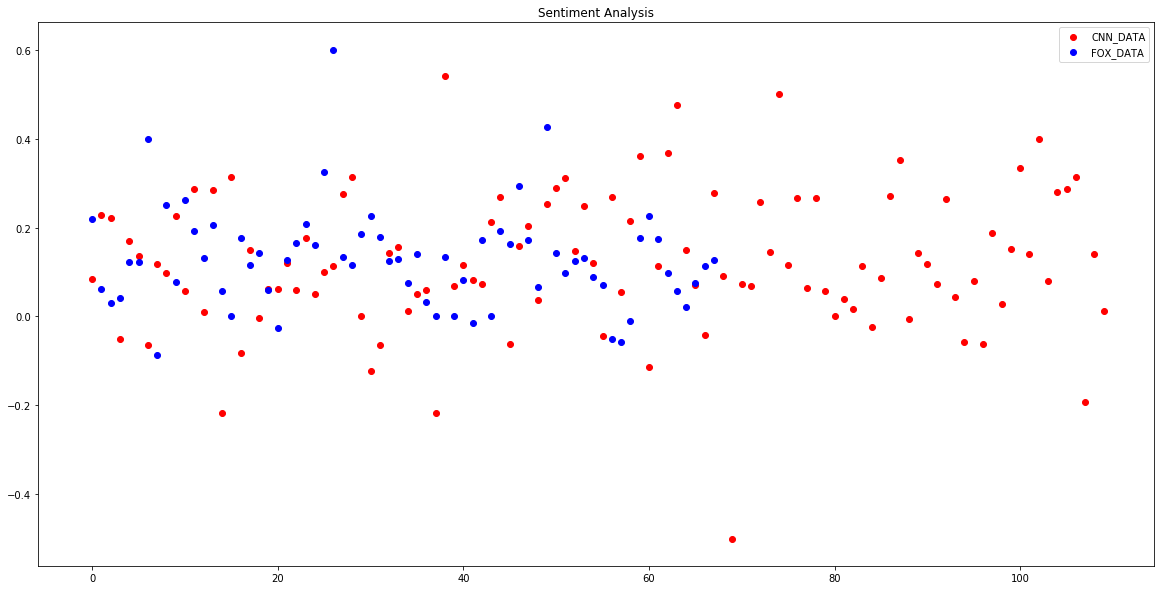

In [91]:
plt.figure(figsize=(20,10))
plt.scatter(range(len(cnn_sa)),cnn_sa,color = 'red',label = 'CNN_DATA')
plt.scatter(range(len(fox_sa)),fox_sa,color = 'blue',label = 'FOX_DATA')
plt.title('Sentiment Analysis')
plt.legend()

Sentiments look postivie mostly. Sentiments are considered only if their subjectivity is more than 0.5 because objective sentences are rarely have any sentiments.

## Applying LDA and LSI Representation

In [192]:
from gensim import corpora, models

In [193]:
corpus = fox_docs + cnn_docs

In [194]:
stop_words = nltk.corpus.stopwords.words('english')
print(len(stop_words))

153


Cleaning the corpus--> Converting to lower -> tokeknizing -> removing Non-alphanumerical words -> removing any punctuation added at last position

In [195]:
import re
pat = r'\w+'
def clean(line):
    line = line.lower()
    words = nltk.word_tokenize(line)
    words = [w for w in words if re.match(pat,w) and w not in stop_words]
    word= []
    for w in words:
        if not w[-1].isalnum():
            word.append(w[:-1])
        else:
            word.append(w)
    return word

In [196]:
corpus = [clean(doc) for doc in corpus]

Givng a unique id to each word in corpus

In [197]:
dictionary = corpora.Dictionary(corpus)
len(dictionary)

15608

In sklearn BagofWords model, it is sparse matrix meaning even if a token is not present then 0 will be put in.On the other hand in gensim BoW model has different vector representation. Token not present won't be shown in representation.

In [198]:
corpus_doc2bow = [dictionary.doc2bow(text) for text in corpus]

In [199]:
lsi = models.LsiModel(corpus_doc2bow, id2word=dictionary, num_topics=5)
lsi.print_topics(5)

[(0,
  '0.332*"n\'t" + 0.254*"think" + 0.227*"know" + 0.222*"going" + 0.196*"clinton" + 0.175*"trump" + 0.175*"people" + 0.154*"president" + 0.151*"right" + 0.135*"well"'),
 (1,
  '-0.625*"clinton" + -0.209*"email" + 0.192*"think" + -0.187*"state" + -0.172*"emails" + 0.165*"n\'t" + -0.162*"fbi" + -0.154*"department" + -0.126*"hillary" + -0.125*"server"'),
 (2,
  '0.322*"comey" + 0.294*"bolling" + 0.236*"fbi" + -0.204*"tax" + 0.187*"williams" + 0.163*"timpf" + 0.159*"emanuel" + 0.144*"hannah" + -0.142*"well" + 0.130*"buchanan"'),
 (3,
  '-0.324*"tax" + 0.177*"guilfoyle" + 0.169*"n\'t" + -0.162*"comey" + 0.161*"perino" + 0.157*"video" + 0.154*"kelly" + 0.149*"clip" + 0.135*"trump" + 0.134*"gutfeld"'),
 (4,
  '0.295*"trump" + 0.216*"president" + 0.189*"news" + -0.187*"guilfoyle" + 0.164*"hannity" + 0.155*"comey" + -0.154*"clinton" + 0.141*"hannah" + 0.140*"fox" + -0.140*"gutfeld"')]

Trying to learn topics in BoW model is not giving significant symantically related words(topic)

Now,applying TfIdf -------->

In [205]:
tfidf = models.TfidfModel(corpus_doc2bow)
corpus_tfidf = [tfidf[text] for text in corpus_doc2bow]
lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=2)
lsi.print_topics(2)

[(0,
  '0.158*"comey" + 0.133*"trump" + 0.116*"fbi" + 0.104*"think" + 0.097*"going" + 0.089*"know" + 0.085*"n\'t" + 0.081*"right" + 0.079*"classified" + 0.078*"people"'),
 (1,
  '0.216*"pagliano" + -0.181*"susteren" + -0.133*"think" + -0.119*"clip" + -0.111*"going" + -0.107*"right" + 0.105*"fbi" + 0.105*"department" + -0.104*"know" + 0.102*"comey"')]

In [211]:
lda = models.LdaModel(corpus_tfidf, id2word=dictionary, num_topics=2)
lda.print_topics(2)

[(0,
  '0.000*"comey" + 0.000*"trump" + 0.000*"fbi" + 0.000*"sanders" + 0.000*"think" + 0.000*"pagliano" + 0.000*"know" + 0.000*"personal" + 0.000*"classified" + 0.000*"right"'),
 (1,
  '0.000*"trump" + 0.000*"comey" + 0.000*"fbi" + 0.000*"think" + 0.000*"department" + 0.000*"n\'t" + 0.000*"wikileaks" + 0.000*"going" + 0.000*"classified" + 0.000*"obama"')]